In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import scipy.interpolate
from multiprocessing import Process
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter

In [2]:
%matplotlib inline

In [3]:
training_data_path = "./original/train/"
validation_data_path = "./original/pubtest/"
test_data_path = "./original/prvtest/"

In [4]:
def create_sentiment_column_from_one_hot(anger, sad, disgust, happy, scared, neutral):
    number = 5
    if anger == 1: 
        number = 0
    elif sad == 1:
        number = 1
    elif disgust == 1:
        number = 2
    elif happy == 1:
        number = 3
    elif scared == 1:
        number = 4
    elif neutral == 1:
        number = 5
    return number

In [5]:
def add_columns(number):
    columns = []
    for i in range(0, number):
        columns.append("Feature" + str(i))
    columns = ["Time"] + columns
    return columns

In [6]:
def assign_column_names(modality):
    if modality == "audio":
        columns = add_columns(36)
    elif modality == "eyes":
        columns = add_columns(6)
    elif modality == "face_nn":
        columns = add_columns(100)
    elif modality == "kinect":
        columns = add_columns(27)
    
    return columns

In [7]:
def append_score_to_files(desiredPath, modality, fileNames):
    column_names = assign_column_names(modality)
    dataFrames = []
    for i in fileNames:
        dfData = pd.read_csv(desiredPath+modality+"/"+i, index_col = None, names = column_names, engine = 'python', skiprows = 1)
        dfLabelData = pd.read_csv(desiredPath+modality+"/"+"../labels/"+i, index_col = None, engine = 'python')
        
        dfLabelData['Sentiment'] = dfLabelData.apply(lambda row: create_sentiment_column_from_one_hot(row['Anger'],row['Sad'], row['Disgust'], row['Happy'], row['Scared'], row['Neutral']), axis = 1)

        dfLabelData.drop("Anger", axis = 1, inplace=True)
        dfLabelData.drop("Sad", axis = 1, inplace=True)
        dfLabelData.drop("Disgust", axis = 1, inplace=True)
        dfLabelData.drop("Happy", axis = 1, inplace=True)
        dfLabelData.drop("Scared", axis = 1, inplace=True)
        dfLabelData.drop("Neutral", axis = 1, inplace=True)

        dfData = pd.merge_asof(dfData, 
                           dfLabelData,
                           on = 'Time',
                           direction = 'nearest')
        
        dfData.drop(dfData.columns[[0]], axis = 1, inplace=True)
        dataFrames.append(dfData)
    return dataFrames 

In [8]:
def prepare_data_lstm(working_data_path, modality, method):
    file_names = os.listdir(working_data_path+modality+"/")
    random.shuffle(file_names)
    total_data_frames = append_score_to_files(working_data_path, modality, file_names)
        
    data_frame = pd.concat(total_data_frames)    

    data_frame.to_csv("./processed/rnn_" + modality + "_" + method + ".csv", index = False)

In [9]:
def find_all_files_present_in_all_modalities(working_path):
    totalFiles = os.listdir(working_path + "labels")
    filesDict = dict(zip(totalFiles, [0]*len(totalFiles)))
    files_common = []
    for key, value in filesDict.items():
        if os.path.isfile(working_path+"audio/"+key):
            filesDict[key] += 1
        if os.path.isfile(working_path+"eyes/"+key):
            filesDict[key] += 1
        if os.path.isfile(working_path+"face_nn/"+key):
            filesDict[key] += 1
        if os.path.isfile(working_path+"kinect/"+key):
            filesDict[key] += 1
        if filesDict[key] == 4:
                files_common.append(key)
    return files_common

In [10]:
def prepare_data_late_fusion(working_data_path, method):
    file_names = find_all_files_present_in_all_modalities(working_data_path)
    random.shuffle(file_names)
    
    modalities = ["audio", "face_nn", "eyes", "kinect"]
    
    for i in modalities:
        data_frames = append_score_to_files(working_data_path, i, file_names)
        data_frame = pd.concat(data_frames)
        data_frame.to_csv("./processed/fusion_" + i + "_" + method + ".csv", index = False)

In [13]:
if __name__ == '__main__':
    p1 = Process(target= prepare_data_lstm, args=(training_data_path, "audio", "train",))
    p1.start()
    p2 = Process(target = prepare_data_lstm, args=(training_data_path, "eyes", "train",))
    p2.start()
    p3 = Process(target = prepare_data_lstm, args=(training_data_path, "face_nn", "train",))
    p3.start()
    p4 = Process(target = prepare_data_lstm, args=(training_data_path, "kinect", "train",))
    p4.start()
    p5 = Process(target= prepare_data_lstm, args=(validation_data_path, "audio", "validation",))
    p5.start()
    p6 = Process(target= prepare_data_lstm, args=(validation_data_path, "eyes", "validation",))
    p6.start()
    p7 = Process(target= prepare_data_lstm, args=(validation_data_path, "face_nn", "validation",))
    p7.start()
    p8 = Process(target= prepare_data_lstm, args=(validation_data_path, "kinect", "validation",))
    p8.start()
    p9 = Process(target = prepare_data_late_fusion, args=(training_data_path, "train",))
    p9.start()
    p10 = Process(target = prepare_data_late_fusion, args=(validation_data_path, "validation",))
    p10.start()

    p11 = Process(target = prepare_data_late_fusion, args=(test_data_path, "test",))
    p11.start()
    
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    p6.join()
    p7.join()
    p8.join()
    p9.join()
    p10.join()
    p11.join()

In [11]:
class Dataset_Train(Dataset):
    def __init__(self, file_path):
        xy = pd.read_csv(file_path,
                       delimiter = ",",
                       skiprows = 1,
                       dtype = np.float32)
        xy = xy.values
        self.len = xy.shape[0]
        self.x_data = torch.FloatTensor(xy[:, 0:-2])
        self.y_data = torch.LongTensor(xy[:, [-1]])
        self.agreement_score = torch.FloatTensor(xy[:, xy[:, 0:-2].shape[1]:-1])
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index], self.agreement_score[index]
    
    def __len__(self):
        return self.len

In [12]:
MINI_BATCH_SIZE = 24
SEQUENCE_SIZE_AUDIO = 40000
SEQUENCE_SIZE_FACE = 20000
SEQUENCE_SIZE_EYES = 20000
SEQUENCE_SIZE_KINECT = 6000
SEQUENCE_SIZE_FUSION = 40000
CUDA_LAUNCH_BLOCKING = 1

In [13]:
training_rnn_audio_dataset = Dataset_Train("./processed/rnn_audio_train.csv")
validation_rnn_audio_dataset = Dataset_Train("./processed/rnn_audio_validation.csv")

train_rnn_audio_loader = DataLoader(dataset = training_rnn_audio_dataset,
                         batch_size = MINI_BATCH_SIZE * SEQUENCE_SIZE_AUDIO,
                         shuffle = False,
                         num_workers = 8)

validation_rnn_audio_loader = DataLoader(dataset = validation_rnn_audio_dataset,
                         batch_size = MINI_BATCH_SIZE * SEQUENCE_SIZE_AUDIO,
                         shuffle = False,
                         num_workers = 8)

In [40]:
training_rnn_face_dataset = Dataset_Train("./processed/rnn_face_nn_train.csv")
validation_rnn_face_dataset = Dataset_Train("./processed/rnn_face_nn_validation.csv")

train_rnn_face_loader = DataLoader(dataset = training_rnn_face_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_FACE,
                         shuffle = False,
                         num_workers = 8)

validation_rnn_face_loader = DataLoader(dataset = validation_rnn_face_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_FACE,
                         shuffle = False,
                         num_workers = 8)

In [41]:
training_rnn_eyes_dataset = Dataset_Train("./processed/rnn_eyes_train.csv")
validation_rnn_eyes_dataset = Dataset_Train("./processed/rnn_eyes_validation.csv")

train_rnn_eyes_loader = DataLoader(dataset = training_rnn_eyes_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_EYES,
                         shuffle = False,
                         num_workers = 8)

validation_rnn_eyes_loader = DataLoader(dataset = validation_rnn_eyes_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_EYES,
                         shuffle = False,
                         num_workers = 8)

In [42]:
training_rnn_kinect_dataset = Dataset_Train("./processed/rnn_kinect_train.csv")
validation_rnn_kinect_dataset = Dataset_Train("./processed/rnn_kinect_validation.csv")

train_rnn_kinect_loader = DataLoader(dataset = training_rnn_kinect_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_KINECT,
                         shuffle = False,
                         num_workers = 8)

validation_rnn_kinect_loader = DataLoader(dataset = validation_rnn_kinect_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_KINECT,
                         shuffle = False,
                         num_workers = 8)

In [13]:
training_fusion_audio_dataset = Dataset_Train("./processed/fusion_audio_train.csv")
validation_fusion_audio_dataset = Dataset_Train("./processed/fusion_audio_validation.csv")

train_fusion_audio_loader = DataLoader(dataset = training_fusion_audio_dataset,
                         batch_size = MINI_BATCH_SIZE * SEQUENCE_SIZE_AUDIO,
                         shuffle = False,
                         num_workers = 8)

validation_fusion_audio_loader = DataLoader(dataset = validation_fusion_audio_dataset,
                         batch_size = MINI_BATCH_SIZE * SEQUENCE_SIZE_AUDIO,
                         shuffle = False,
                         num_workers = 8)

In [14]:
training_fusion_face_dataset = Dataset_Train("./processed/fusion_face_nn_train.csv")
validation_fusion_face_dataset = Dataset_Train("./processed/fusion_face_nn_validation.csv")

train_fusion_face_loader = DataLoader(dataset = training_fusion_face_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_FACE,
                         shuffle = False,
                         num_workers = 8)

validation_fusion_face_loader = DataLoader(dataset = validation_fusion_face_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_FACE,
                         shuffle = False,
                         num_workers = 8)

In [15]:
training_fusion_eyes_dataset = Dataset_Train("./processed/fusion_eyes_train.csv")
validation_fusion_eyes_dataset = Dataset_Train("./processed/fusion_eyes_validation.csv")

train_fusion_eyes_loader = DataLoader(dataset = training_fusion_eyes_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_EYES,
                         shuffle = False,
                         num_workers = 8)

validation_fusion_eyes_loader = DataLoader(dataset = validation_fusion_eyes_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_EYES,
                         shuffle = False,
                         num_workers = 8)

In [16]:
training_fusion_kinect_dataset = Dataset_Train("./processed/fusion_kinect_train.csv")
validation_fusion_kinect_dataset = Dataset_Train("./processed/fusion_kinect_validation.csv")

train_fusion_kinect_loader = DataLoader(dataset = training_fusion_kinect_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_KINECT,
                         shuffle = False,
                         num_workers = 8)

validation_fusion_kinect_loader = DataLoader(dataset = validation_fusion_kinect_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_KINECT,
                         shuffle = False,
                         num_workers = 8)

In [17]:
testing_fusion_audio_dataset = Dataset_Train("./processed/fusion_audio_test.csv")

testing_fusion_audio_loader = DataLoader(dataset = testing_fusion_audio_dataset,
                         batch_size = MINI_BATCH_SIZE * SEQUENCE_SIZE_AUDIO,
                         shuffle = False,
                         num_workers = 8)

In [18]:
testing_fusion_face_dataset = Dataset_Train("./processed/fusion_face_nn_test.csv")

testing_fusion_face_loader = DataLoader(dataset = testing_fusion_face_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_FACE,
                         shuffle = False,
                         num_workers = 8)

In [19]:
testing_fusion_eyes_dataset = Dataset_Train("./processed/fusion_eyes_test.csv")

testing_fusion_eyes_loader = DataLoader(dataset = testing_fusion_eyes_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_EYES,
                         shuffle = False,
                         num_workers = 8)

In [20]:
testing_fusion_kinect_dataset = Dataset_Train("./processed/fusion_kinect_test.csv")

testing_fusion_kinect_loader = DataLoader(dataset = testing_fusion_kinect_dataset,
                         batch_size = MINI_BATCH_SIZE*SEQUENCE_SIZE_KINECT,
                         shuffle = False,
                         num_workers = 8)

In [ ]:
print(len(train_rnn_kinect_loader))
print(len(validation_rnn_kinect_loader))

In [21]:
class LSTM(nn.Module):
    def __init__(self, nr_classes, input_size, hidden_size, nr_layers, dropout_lstm, dropout_linear, bidirectional, batch_size):
        super(LSTM, self).__init__()
        
        self.nr_classes = nr_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nr_layers = nr_layers
        self.batch_size = batch_size
        self.dropout = dropout_lstm
        self.nr_directions = 2 if bidirectional else 1

        
        self.lstm = nn.LSTM(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = nr_layers,
                          dropout = self.dropout,
                          bidirectional = bidirectional,
                          batch_first = True)
        self.hidden_to_label = nn.Sequential(
            nn.Linear(hidden_size * self.nr_directions, hidden_size),
            nn.ReLU(True),
            nn.Dropout(p = dropout_linear),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Dropout(p = dropout_linear),
            nn.Linear(hidden_size, nr_classes)
        )
        
        
    
    def forward(self, x):        
        x.view(self.batch_size, x.size(1), self.input_size)        
        
     #   x = x.cpu()
        
        self.lstm.flatten_parameters()
        lstm_out, (hidden, cell) = self.lstm(x, self.init_hidden())
        
        y = self.hidden_to_label(lstm_out)
        return y.view(-1, 6)
    
    def init_hidden(self):
        if torch.cuda.is_available():
            hidden = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size).cuda())
            cell = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size).cuda())
        else:
            hidden = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size))
            cell = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size))
        return (hidden, cell)

In [22]:
class LSTMEyes(nn.Module):
    def __init__(self, nr_classes, input_size, hidden_size, nr_layers, dropout_lstm, dropout_linear, bidirectional, batch_size):
        super(LSTMEyes, self).__init__()
        
        self.nr_classes = nr_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nr_layers = nr_layers
        self.batch_size = batch_size
        self.dropout = dropout_lstm
        self.nr_directions = 2 if bidirectional else 1

        
        self.lstm = nn.LSTM(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = nr_layers,
                          dropout = self.dropout,
                          bidirectional = bidirectional,
                          batch_first = True)
        self.hidden_to_label = nn.Sequential(
            nn.Linear(hidden_size * self.nr_directions, hidden_size),
            nn.ReLU(True),
            nn.Dropout(p = dropout_linear),
            nn.Linear(hidden_size, nr_classes)
        #    nn.ReLU(True),
        #    nn.Dropout(p = dropout_linear),
        #    nn.Linear(hidden_size, nr_classes)
        )
        
        
    
    def forward(self, x):        
        x.view(self.batch_size, x.size(1), self.input_size)        

        
        self.lstm.flatten_parameters()
        #print(x.type())
        (hidden, cell) = self.init_hidden()
       # print(hidden.type())
        #print(cell.type())
        lstm_out, (hidden, cell) = self.lstm(x, self.init_hidden())
        
        y = self.hidden_to_label(lstm_out)
        return y.view(-1, 6)
    
    def init_hidden(self):
        if torch.cuda.is_available():
            hidden = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size).cuda())
            cell = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size).cuda())
        else:
            hidden = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size))
            cell = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size))
        return (hidden, cell)

In [8]:
audio_lstm_model = LSTM(nr_classes = 6,
           input_size = 36,
           hidden_size = 20,
           nr_layers = 3,
           dropout_lstm = 0.2,
           dropout_linear = 0.5,
           bidirectional = False,
           batch_size = MINI_BATCH_SIZE).cuda()

print(audio_lstm_model)

LSTM(
  (lstm): LSTM(36, 20, num_layers=3, batch_first=True, dropout=0.2)
  (hidden_to_label): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=20, out_features=6, bias=True)
  )
)


In [9]:
face_lstm_model = LSTM(nr_classes = 6,
           input_size = 100,
           hidden_size = 50,
           nr_layers = 3,
           dropout_lstm = 0.2,
           dropout_linear = 0.5,
           bidirectional = False,
           batch_size = MINI_BATCH_SIZE).cuda()

print(face_lstm_model)

LSTM(
  (lstm): LSTM(100, 50, num_layers=3, batch_first=True, dropout=0.2)
  (hidden_to_label): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=50, out_features=6, bias=True)
  )
)


In [58]:
eyes_lstm_model = LSTM(nr_classes = 6,
           input_size = 6,
           hidden_size = 20,
           nr_layers = 3,
           dropout_lstm = 0.2,
           dropout_linear = 0.5,
           bidirectional = False,
           batch_size = MINI_BATCH_SIZE).cuda()

print(eyes_lstm_model)

LSTM(
  (lstm): LSTM(6, 20, num_layers=3, batch_first=True, dropout=0.2)
  (hidden_to_label): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=20, out_features=6, bias=True)
  )
)


In [21]:
kinect_lstm_model = LSTM(nr_classes = 6,
           input_size = 27,
           hidden_size = 14,
           nr_layers = 3,
           dropout_lstm = 0.2,
           dropout_linear = 0.5,
           bidirectional = False,
           batch_size = MINI_BATCH_SIZE).cuda()

print(kinect_lstm_model)

LSTM(
  (lstm): LSTM(27, 14, num_layers=3, batch_first=True, dropout=0.2)
  (hidden_to_label): Sequential(
    (0): Linear(in_features=14, out_features=14, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=14, out_features=14, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=14, out_features=6, bias=True)
  )
)


In [23]:
class Fusion_model(nn.Module):
    def __init__(self, nr_classes, input_size, dropout_linear,batch_size):
        super(Fusion_model, self).__init__()
        
        self.nr_classes = nr_classes
        self.input_size = input_size
        self.dropout_linear = dropout_linear
        self.batch_size = batch_size
        self.hidden_to_label = nn.Sequential(
        nn.Linear(self.input_size, 80),
        nn.ReLU(True),
        nn.Dropout(p = self.dropout_linear),
        nn.Linear(80, 40),
        nn.ReLU(True),
        nn.Dropout(p = self.dropout_linear),
        nn.Linear(40, 6)
        )
    
    def forward(self, x):
        #print("Input size: ", x.size())
        x.view(self.batch_size, x.size(1), self.input_size)
        #print("Input after resize: ", x.size())
        #lstm_out, (hidden, cell) = self.lstm(x, self.init_hidden())
        y = self.hidden_to_label(x)
        #print("Output size: ", y.size())
        return y.view(-1, 6)
    
  #  def init_hidden(self):
  #      if torch.cuda.is_available():
  #          hidden0 = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size).cuda())
  #          cell0 = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size).cuda())
  #      else:
  #          hidden0 = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size))
  #          cell0 = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size))
  #      return (hidden0, cell0)

In [14]:
class LSTMFusion(nn.Module):
    def __init__(self, nr_classes, input_size, hidden_size, nr_layers, dropout_lstm, dropout_linear, bidirectional, batch_size):
        super(LSTMFusion, self).__init__()
        
        self.nr_classes = nr_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nr_layers = nr_layers
        self.batch_size = batch_size
        self.dropout = dropout_lstm
        self.nr_directions = 2 if bidirectional else 1

        
        self.lstm = nn.LSTM(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = nr_layers,
                          dropout = self.dropout,
                          bidirectional = bidirectional,
                          batch_first = True)
        self.hidden_to_label = nn.Sequential(
            nn.Linear(hidden_size * self.nr_directions, hidden_size),
            nn.ReLU(True),
            nn.Dropout(p = dropout_linear),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Dropout(p = dropout_linear),
            nn.Linear(hidden_size, nr_classes)
        )
        
        
    
    def forward(self, x):        
        x.view(self.batch_size, x.size(1), self.input_size)        
        
     #   x = x.cpu()
        
        self.lstm.flatten_parameters()
        lstm_out, (hidden, cell) = self.lstm(x, self.init_hidden())
        
        y = self.hidden_to_label(lstm_out)
        return y.view(-1, 6)
    
    def init_hidden(self):
        if torch.cuda.is_available():
            hidden = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size).cuda())
            cell = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size).cuda())
        else:
            hidden = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size))
            cell = Variable(torch.zeros(self.nr_layers*self.nr_directions, self.batch_size, self.hidden_size))
        return (hidden, cell)

In [24]:
fusion_model = Fusion_model(nr_classes = 6,
                            input_size = 24,
                            dropout_linear = 0.5,
                            batch_size = MINI_BATCH_SIZE).cuda()
print(fusion_model)

Fusion_model(
  (hidden_to_label): Sequential(
    (0): Linear(in_features=24, out_features=80, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=80, out_features=40, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=40, out_features=6, bias=True)
  )
)


In [15]:
fusion_model = LSTMFusion(nr_classes = 6,
           input_size = 24,
           hidden_size = 20,
           nr_layers = 3,
           dropout_lstm = 0.2,
           dropout_linear = 0.5,
           bidirectional = False,
           batch_size = MINI_BATCH_SIZE).cuda()

print(fusion_model)

LSTMFusion(
  (lstm): LSTM(24, 20, num_layers=3, batch_first=True, dropout=0.2)
  (hidden_to_label): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU(inplace)
    (2): Dropout(p=0.5)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): ReLU(inplace)
    (5): Dropout(p=0.5)
    (6): Linear(in_features=20, out_features=6, bias=True)
  )
)


In [27]:
fusion_model = torch.load("./model/final_fushion_3LayerWide")

In [9]:
criterion = nn.CrossEntropyLoss(size_average=True, reduce=False)
optimizer = torch.optim.Adam(audio_lstm_model.parameters(), lr = 0.01)

In [18]:
criterion = nn.CrossEntropyLoss(size_average=True, reduce=False)
optimizer = torch.optim.Adam(face_lstm_model.parameters(), lr = 0.001)

In [59]:
criterion = nn.CrossEntropyLoss(size_average=True, reduce=False)
optimizer = torch.optim.Adam(eyes_lstm_model.parameters(), lr = 0.01)

In [68]:
criterion = nn.CrossEntropyLoss(size_average=False, reduce=False)
optimizer = torch.optim.Adam(kinect_lstm_model.parameters(), lr = 0.01)

NameError: name 'kinect_lstm_model' is not defined

In [25]:
criterion = nn.CrossEntropyLoss(size_average=True)
optimizer = torch.optim.Adam(fusion_model.parameters(), lr = 0.01)

In [26]:
train_accuracy = []
validation_accuracy = []
train_epochs =  []
validation_epochs = []
train_loss = []
validation_loss = []

In [27]:
def padd_incomplete_sequences(inputs, labels, agreement_score, mini_batch_size, sequence_size):
 
    input_target = torch.Tensor(torch.zeros(mini_batch_size, sequence_size, inputs.size(1)))
    labels_target = torch.Tensor(torch.zeros(mini_batch_size*sequence_size))
    agreement_score_target = torch.Tensor(torch.zeros(mini_batch_size*sequence_size))

    
    input_target = input_target.reshape(-1, inputs.size(1))
    labels_source = labels.squeeze()
    agreement_score_source = agreement_score.squeeze()


    input_target[:inputs.size(0)] = inputs
    labels_target[:labels.size(0)] = labels_source
    agreement_score_target[:agreement_score.size(0)] = agreement_score_source
    
    input_target = input_target.reshape(mini_batch_size, sequence_size, inputs.size(1))
    input_target = input_target.type(torch.FloatTensor)
    labels_target = labels_target.type(torch.LongTensor)
    agreement_score_target = agreement_score_target.type(torch.FloatTensor)
    
    return (input_target, labels_target, agreement_score_target)
    

In [28]:
def padd_incomplete_sequence_inputs(inputs, mini_batch_size, sequence_size):
 
    input_target = torch.Tensor(torch.zeros(mini_batch_size, sequence_size, inputs.size(1)))

    input_target = input_target.reshape(-1, inputs.size(1))

    input_target[:inputs.size(0)] = inputs
    
    input_target = input_target.reshape(mini_batch_size, sequence_size, inputs.size(1))
    input_target = input_target.type(torch.FloatTensor)
    
    return input_target
    

In [29]:
def padd_incomplete_sequence_labels(labels, mini_batch_size, sequence_size):
 
    labels_target = torch.Tensor(torch.zeros(mini_batch_size*sequence_size))
    
    labels_source = labels.squeeze()

    labels_target[:labels.size(0)] = labels_source
    
    labels_target = labels_target.type(torch.LongTensor)
    
    return labels_target

In [30]:
def train(model, loader, epoch, mini_batch_size, sequence_size):
    model.train()
    correct = 0
    padded_size = 0
    size_input = mini_batch_size * sequence_size
    for batch_idx, (inputs, labels, agreement_score) in enumerate(loader):
        
        
        if(inputs.size(0) == size_input):
            inputs = inputs.clone().reshape(mini_batch_size, sequence_size, inputs.size(1))
            labels = labels.clone().squeeze().reshape(mini_batch_size*sequence_size)
            agreement_score = agreement_score.clone().squeeze().reshape(mini_batch_size*sequence_size)
        else:
            padded_size = size_input - inputs.size(0)
            (inputs, labels, agreement_score) = padd_incomplete_sequences(inputs, labels, agreement_score, mini_batch_size, sequence_size)
            
        
        
        inputs, labels, agreement_score = Variable(inputs.cuda()), Variable(labels.cuda()), Variable(agreement_score.cuda())
       
        
        output = model(inputs)
        
        
        loss = criterion(output, labels)
        loss = loss * agreement_score
        loss = loss.mean()
        
        optimizer.zero_grad()
        loss.backward()
            
        optimizer.step()
        
        pred = output.data.max(1, keepdim = True)[1]
        correct += pred.eq(labels.data.view_as(pred)).cuda().sum()
        
        accuracy = 100. * correct / (len(loader.dataset) + padded_size)
        
        print("Train: Epoch: {}, [{}/{} ({:.0f}%)]\t loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)".format(
            epoch,
            (batch_idx+1) * len(output),
            (len(loader.dataset) + padded_size),
            100. * (batch_idx +1) / (len(loader.dataset)+padded_size),
            loss.item(),
            correct,
            (len(loader.dataset) + padded_size),
            accuracy))
        
    accuracy = 100. * correct / (len(loader.dataset) + padded_size)
    
    train_accuracy.append(accuracy)
    train_epochs.append(epoch)
    train_loss.append(loss.item())

In [31]:
audio_model = torch.load("./model/audio_lstm24x40000lowlr")

In [32]:
face_model = torch.load("./model/final_face_lstm24X20000highlr")

In [33]:
eyes_model = torch.load("./model/eyes_lstm50x20000_10epochs_new_architecture")

In [34]:
kinect_model = torch.load("./model/kinect_lstm24x6000_500epochs")

In [35]:
def interpolate_arrays(source, target_size):
    x = source.cpu().numpy()
    indexes = np.arange(0, x.shape[0])
    fit = scipy.interpolate.interp1d(indexes, x, axis = 0)
    result = fit(np.linspace(0, x.shape[0] - 1, target_size))
    return result

In [36]:
def get_output_from_model(model, inputs, mini_batch_size, sequence_size):
    with torch.no_grad():
        model.eval()
        padded_size = 0
        size_input = mini_batch_size * sequence_size
        test_loss = 0
        correct =0
        if(inputs.size(0) == size_input):
            inputs = inputs.clone().reshape(mini_batch_size, sequence_size, inputs.size(1))
        else:
            padded_size = size_input - inputs.size(0)
            inputs = padd_incomplete_sequence_inputs(inputs, mini_batch_size, sequence_size)


        inputs = Variable(inputs.cuda())


        output = model(inputs)
    return output    

In [52]:
def get_output_from_model_cpu(model, inputs, mini_batch_size, sequence_size):
    model.eval()
    padded_size = 0
    size_input = mini_batch_size * sequence_size
    test_loss = 0
    correct =0
    if(inputs.size(0) == size_input):
        inputs = inputs.clone().reshape(mini_batch_size, sequence_size, inputs.size(1))
    else:
        padded_size = size_input - inputs.size(0)
        inputs = padd_incomplete_sequence_inputs(inputs, mini_batch_size, sequence_size)


    inputs = Variable(inputs.cpu())

    output = model(inputs)
    
    return output  

In [37]:
def create_input_fusion(audio, face, eyes, kinect):
    with torch.no_grad():
        fusion_audio = audio.cpu().float()
        fusion_face = torch.from_numpy(interpolate_arrays(face, audio.size(0))).float()
        fusion_eyes = torch.from_numpy(interpolate_arrays(eyes, audio.size(0))).float()
        fusion_kinect = torch.from_numpy(interpolate_arrays(kinect, audio.size(0))).float()
    
    
    result = torch.cat((fusion_audio, fusion_face, fusion_eyes, fusion_kinect), 1)
    result = result.cuda()
    return result    

In [38]:
def train_fusion(model, audio_model, face_model, eyes_model, kinect_model, epoch, mini_batch_size, sequence_size, audio_sequence_size, face_sequence_size, eyes_sequence_size, kinect_sequence_size):
    audio_model.eval()
    face_model.eval()
    eyes_model.eval()
    kinect_model.eval()
    model.train()
    correct = 0
    size_input = mini_batch_size * sequence_size
    
    for (audio, face, eyes, kinect) in zip(enumerate(train_fusion_audio_loader), enumerate(train_fusion_face_loader), enumerate(train_fusion_eyes_loader), enumerate(train_fusion_kinect_loader)):
        audio_batch_idx, (audio_inputs, labels, _) = audio
        face_batch_idx, (face_inputs, _, _) = face
        eyes_batch_idx, (eyes_inputs, _, _) = eyes
        kinect_batch_idx, (kinect_inputs, _, _) = kinect        
        
        result_audio = get_output_from_model(audio_model, audio_inputs, mini_batch_size, audio_sequence_size)
        result_face = get_output_from_model(face_model, face_inputs, mini_batch_size, face_sequence_size)
        result_eyes = get_output_from_model(eyes_model, eyes_inputs, mini_batch_size, eyes_sequence_size)
        result_kinect = get_output_from_model(kinect_model, kinect_inputs, mini_batch_size, kinect_sequence_size)
        
        input_fusion = create_input_fusion(result_audio, result_face, result_eyes, result_kinect)  
        
        input_fusion = input_fusion.reshape(mini_batch_size, sequence_size, input_fusion.size(1))
        labels= padd_incomplete_sequence_labels(labels, mini_batch_size, sequence_size)
        
        labels = Variable(labels.cuda())
        
        output = model(input_fusion)
        
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim = True)[1]
        correct += pred.eq(labels.data.view_as(pred)).sum()
        
        accuracy = 100. * correct / (size_input)
        
        print("Train: Epoch: {}, [{}/{} ({:.0f}%)]\t loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)".format(
            epoch,
            (audio_batch_idx+1)*len(output),
            size_input,
            100. * (audio_batch_idx+1) / size_input,
            loss.item(),
            correct,
            size_input,
            accuracy))
        
    accuracy = 100. * correct / size_input
    
    train_accuracy.append(accuracy)
    train_epochs.append(epoch)
    train_loss.append(loss.item())

In [39]:
def evaluation_fusion(model, audio_model, face_model, eyes_model, kinect_model, epoch, mini_batch_size, sequence_size, audio_sequence_size, face_sequence_size, eyes_sequence_size, kinect_sequence_size):
    audio_model.eval()
    face_model.eval()
    eyes_model.eval()
    kinect_model.eval()
    model.eval()
    correct = 0
    test_loss = 0
    size_input = mini_batch_size * sequence_size
    with torch.no_grad():
        for (audio, face, eyes, kinect) in zip(enumerate(validation_fusion_audio_loader), enumerate(validation_fusion_face_loader), enumerate(validation_fusion_eyes_loader), enumerate(validation_fusion_kinect_loader)):
            audio_batch_idx, (audio_inputs, labels, _) = audio
            face_batch_idx, (face_inputs, _, _) = face
            eyes_batch_idx, (eyes_inputs, _, _) = eyes
            kinect_batch_idx, (kinect_inputs, _, _) = kinect        

            result_audio = get_output_from_model(audio_model, audio_inputs, mini_batch_size, audio_sequence_size)
            result_face = get_output_from_model(face_model, face_inputs, mini_batch_size, face_sequence_size)
            result_eyes = get_output_from_model(eyes_model, eyes_inputs, mini_batch_size, eyes_sequence_size)
            result_kinect = get_output_from_model(kinect_model, kinect_inputs, mini_batch_size, kinect_sequence_size)

            input_fusion = create_input_fusion(result_audio, result_face, result_eyes, result_kinect)  

            input_fusion = input_fusion.reshape(mini_batch_size, sequence_size, input_fusion.size(1))
            labels= padd_incomplete_sequence_labels(labels, mini_batch_size, sequence_size)
            
            labels = Variable(labels.cuda())
                
            output = model(input_fusion)

            loss = criterion(output, labels)

            test_loss += loss.item()

            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
            
    accuracy = 100. * correct / size_input
    
    validation_accuracy.append(accuracy)
    validation_loss.append(loss.item())
    validation_epochs.append(epoch)
    
    #test_loss /= len(test_loader.dataset)
    print('\nValidation set: loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss,
    correct,
    size_input,
    accuracy))

In [40]:
def testing_fusion(model, audio_model, face_model, eyes_model, kinect_model, epoch, mini_batch_size, sequence_size, audio_sequence_size, face_sequence_size, eyes_sequence_size, kinect_sequence_size):
    audio_model.eval()
    face_model.eval()
    eyes_model.eval()
    kinect_model.eval()
    model.eval()
    correct = 0
    test_loss = 0
    size_input = mini_batch_size * sequence_size
    with torch.no_grad():
        for (audio, face, eyes, kinect) in zip(enumerate(testing_fusion_audio_loader), enumerate(testing_fusion_face_loader), enumerate(testing_fusion_eyes_loader), enumerate(testing_fusion_kinect_loader)):
            audio_batch_idx, (audio_inputs, labels, _) = audio
            face_batch_idx, (face_inputs, _, _) = face
            eyes_batch_idx, (eyes_inputs, _, _) = eyes
            kinect_batch_idx, (kinect_inputs, _, _) = kinect        

            result_audio = get_output_from_model(audio_model, audio_inputs, mini_batch_size, audio_sequence_size)
            result_face = get_output_from_model(face_model, face_inputs, mini_batch_size, face_sequence_size)
            result_eyes = get_output_from_model(eyes_model, eyes_inputs, mini_batch_size, eyes_sequence_size)
            result_kinect = get_output_from_model(kinect_model, kinect_inputs, mini_batch_size, kinect_sequence_size)

            input_fusion = create_input_fusion(result_audio, result_face, result_eyes, result_kinect)  

            input_fusion = input_fusion.reshape(mini_batch_size, sequence_size, input_fusion.size(1))
            labels= padd_incomplete_sequence_labels(labels, mini_batch_size, sequence_size)
            
            labels = Variable(labels.cuda())
                
            output = model(input_fusion)

            loss = criterion(output, labels)

            test_loss += loss.item()

            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
            
    accuracy = 100. * correct / size_input
    
    validation_accuracy.append(accuracy)
    validation_loss.append(loss.item())
    validation_epochs.append(epoch)
    
    #test_loss /= len(test_loader.dataset)
    print('\nTest set: loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss,
    correct,
    size_input,
    accuracy))

In [41]:
def evaluation(model, loader, epoch, mini_batch_size, sequence_size):
    model.eval()
    test_loss = 0
    correct = 0
    padded_size = 0
    size_input = mini_batch_size * sequence_size
    with torch.no_grad():
        for (inputs, labels, agreement_score) in loader:
            if(inputs.size(0) == size_input):
                inputs = inputs.clone().reshape(mini_batch_size, sequence_size, inputs.size(1))
                labels = labels.clone().squeeze().reshape(mini_batch_size*sequence_size)
                agreement_score = agreement_score.clone().squeeze().reshape(mini_batch_size*sequence_size)
            else:
                padded_size = size_input - inputs.size(0)
                (inputs, labels, agreement_score) = padd_incomplete_sequences(inputs, labels, agreement_score, mini_batch_size, sequence_size)


            inputs, labels, agreement_score = Variable(inputs.cuda()), Variable(labels.cuda()), Variable(agreement_score.cuda())


            output = model(inputs)


            loss = criterion(output, labels)
            loss = loss.mean()

            #sum up batch loss
            test_loss += loss.item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cuda().sum()



    accuracy = 100. * correct / (len(loader.dataset) + padded_size)
    
    validation_accuracy.append(accuracy)
    validation_loss.append(loss.item())
    validation_epochs.append(epoch)
    
    #test_loss /= len(test_loader.dataset)
    print('\nValidation set: loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss,
    correct,
    (len(loader.dataset) + padded_size),
    accuracy))
    
        

In [42]:
def plot_results(plot_title, folder_name, x_label, y_label, x_data, y_data):
    plt.title(plot_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.plot(x_data, y_data, color = "r")
    plt.grid()
    plt.savefig("./charts/" + folder_name + "/" + plot_title + ".png", bbox_inches = "tight")

In [31]:
face_lstm_model = torch.load("./model/final_face_lstm24X20000highlr")

In [59]:
for epoch in range(1, 1000):
    train(audio_lstm_model,train_rnn_audio_loader, epoch, MINI_BATCH_SIZE, SEQUENCE_SIZE_AUDIO)
    evaluation(audio_lstm_model,train_rnn_audio_loader, epoch, MINI_BATCH_SIZE, SEQUENCE_SIZE_AUDIO)

NameError: name 'audio_lstm_model' is not defined

In [ ]:
for epoch in range(1, 10):
    train_face(epoch)
    evaluation_face(epoch)

In [43]:
for epoch in range(1, 1000):
    train_fusion(fusion_model, audio_model, face_model, eyes_model, kinect_model, epoch, MINI_BATCH_SIZE, SEQUENCE_SIZE_FUSION, SEQUENCE_SIZE_AUDIO, SEQUENCE_SIZE_FACE, SEQUENCE_SIZE_EYES, SEQUENCE_SIZE_KINECT)
    evaluation_fusion(fusion_model, audio_model, face_model, eyes_model, kinect_model, epoch, MINI_BATCH_SIZE, SEQUENCE_SIZE_FUSION, SEQUENCE_SIZE_AUDIO, SEQUENCE_SIZE_FACE, SEQUENCE_SIZE_EYES, SEQUENCE_SIZE_KINECT)

Train: Epoch: 1, [960000/960000 (0%)]	 loss: 1.863178, Accuracy: 153452/960000 (15%)

Validation set: loss: 1.6551, Accuracy: 565833/960000 (58%)

Train: Epoch: 2, [960000/960000 (0%)]	 loss: 1.739516, Accuracy: 228222/960000 (23%)

Validation set: loss: 1.6453, Accuracy: 567780/960000 (59%)

Train: Epoch: 3, [960000/960000 (0%)]	 loss: 1.704254, Accuracy: 243052/960000 (25%)

Validation set: loss: 1.6467, Accuracy: 575309/960000 (59%)

Train: Epoch: 4, [960000/960000 (0%)]	 loss: 1.683067, Accuracy: 256339/960000 (26%)

Validation set: loss: 1.6307, Accuracy: 574069/960000 (59%)

Train: Epoch: 5, [960000/960000 (0%)]	 loss: 1.662346, Accuracy: 273130/960000 (28%)

Validation set: loss: 1.6145, Accuracy: 577536/960000 (60%)

Train: Epoch: 6, [960000/960000 (0%)]	 loss: 1.641047, Accuracy: 287095/960000 (29%)

Validation set: loss: 1.5971, Accuracy: 581032/960000 (60%)

Train: Epoch: 7, [960000/960000 (0%)]	 loss: 1.619731, Accuracy: 298782/960000 (31%)

Validation set: loss: 1.5795, Ac


Validation set: loss: 1.2795, Accuracy: 579807/960000 (60%)

Train: Epoch: 57, [960000/960000 (0%)]	 loss: 1.481297, Accuracy: 350189/960000 (36%)

Validation set: loss: 1.2718, Accuracy: 579941/960000 (60%)

Train: Epoch: 58, [960000/960000 (0%)]	 loss: 1.480355, Accuracy: 351358/960000 (36%)

Validation set: loss: 1.2587, Accuracy: 580356/960000 (60%)

Train: Epoch: 59, [960000/960000 (0%)]	 loss: 1.479936, Accuracy: 352232/960000 (36%)

Validation set: loss: 1.2585, Accuracy: 580242/960000 (60%)

Train: Epoch: 60, [960000/960000 (0%)]	 loss: 1.479612, Accuracy: 352337/960000 (36%)

Validation set: loss: 1.2404, Accuracy: 580203/960000 (60%)

Train: Epoch: 61, [960000/960000 (0%)]	 loss: 1.478290, Accuracy: 352193/960000 (36%)

Validation set: loss: 1.2431, Accuracy: 580029/960000 (60%)

Train: Epoch: 62, [960000/960000 (0%)]	 loss: 1.477041, Accuracy: 352803/960000 (36%)

Validation set: loss: 1.2511, Accuracy: 579659/960000 (60%)

Train: Epoch: 63, [960000/960000 (0%)]	 loss: 1.47

Process Process-4635:
Process Process-4610:
Process Process-4636:
Process Process-4620:
Process Process-4637:
Process Process-4638:
Process Process-4615:
Process Process-4619:
Process Process-4612:
Process Process-4609:
Process Process-4613:
Process Process-4627:
Process Process-4617:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-4618:
Traceback (most recent call last):
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-4630:
Process Process-4623:
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-4614:
Process Process-4639:
Process Process-4611:
Process Process-4640:
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/process.p

  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-pack

  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 21

  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    

KeyboardInterrupt
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/al

KeyboardInterrupt: 

In [44]:
testing_fusion(fusion_model, audio_model, face_model, eyes_model, kinect_model, epoch, MINI_BATCH_SIZE, SEQUENCE_SIZE_FUSION, SEQUENCE_SIZE_AUDIO, SEQUENCE_SIZE_FACE, SEQUENCE_SIZE_EYES, SEQUENCE_SIZE_KINECT)


Test set: loss: 1.1919, Accuracy: 592128/960000 (61%)



In [45]:
fusion_new_model = torch.load("./model/final_fushion_3LayerWide")

In [46]:
testing_fusion(fusion_new_model, audio_model, face_model, eyes_model, kinect_model, epoch, MINI_BATCH_SIZE, SEQUENCE_SIZE_FUSION, SEQUENCE_SIZE_AUDIO, SEQUENCE_SIZE_FACE, SEQUENCE_SIZE_EYES, SEQUENCE_SIZE_KINECT)


Test set: loss: 1.0322, Accuracy: 588877/960000 (61%)



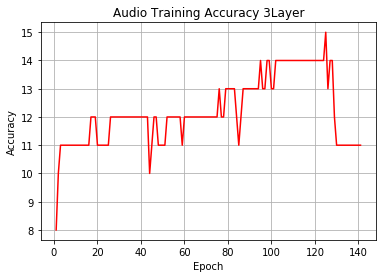

In [21]:
plot_results("Audio Training Accuracy 3Layer","TrainingAccuracy", "Epoch", "Accuracy",train_epochs, train_accuracy)

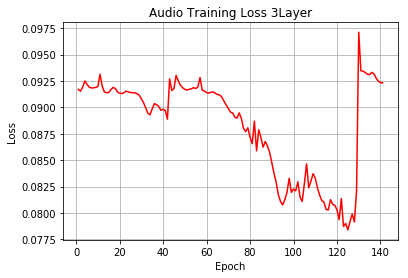

In [22]:
plot_results("Audio Training Loss 3Layer", "TrainingLoss", "Epoch","Loss", train_epochs, train_loss)

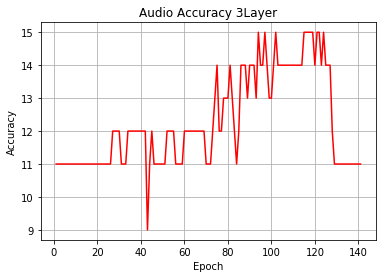

In [23]:
plot_results("Audio Accuracy 3Layer","ValidationAccuracy", "Epoch","Accuracy", validation_epochs, validation_accuracy)

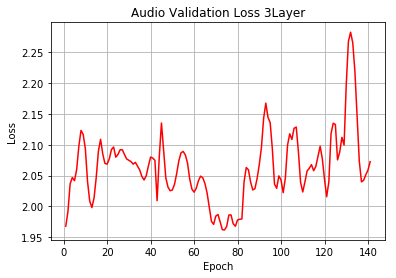

In [24]:
plot_results("Audio Validation Loss 3Layer", "ValidationLoss", "Epoch","Loss", validation_epochs, validation_loss)

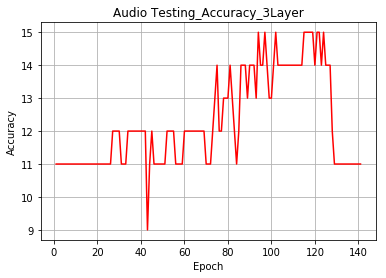

In [25]:
plot_results("Audio Testing_Accuracy_3Layer","ValidationAccuracy", "Epoch","Accuracy", validation_epochs, validation_accuracy)

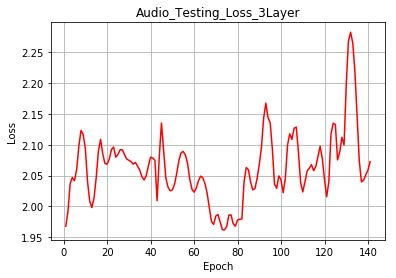

In [26]:
plot_results("Audio_Testing_Loss_3Layer", "ValidationLoss", "Epoch","Loss", validation_epochs, validation_loss)

In [20]:
torch.save(audio_lstm_model, "./model/audio_lstm24x40000lowlr")

/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [26]:
torch.save(face_lstm_model, "./model/final_face_lstm24X20000highlr")

/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [70]:
torch.save(eyes_lstm_model, "./model/eyes_lstm50x20000_10epochs_new_architecture")

/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [33]:
torch.save(kinect_lstm_model, "./model/kinect_lstm24x6000_500epochs")

/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
torch.save(fusion_model, "./model/final_fusion_2layer")

In [37]:
torch.save(fusion_model, "./model/final_fusion_3LSTM3Layer")

/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type LSTMFusion. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [34]:
torch.save(fusion_model, "./model/final_fushion_3LayerWide")

/home/alexandrugh/anaconda3/envs/torch40/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Fusion_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
face_lstm_model = torch.load("./model/face_lstm50")

In [ ]:
fusion_new_model = torch.load("./model/final_fushion_3LayerWide")

In [ ]:
    testing(audio_lstm_model,train_rnn_audio_loader, epoch, MINI_BATCH_SIZE, SEQUENCE_SIZE_AUDIO)